## Topic Modeling with Gensim (Python)
#### https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#:~:text=Topic%20Modeling%20is%20a%20technique,in%20the%20Python's%20Gensim%20package 

In [4]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# plotting tools
import pyLDAvis
import pyLDAvis.gensim_models # pyLDAvis.gensim raises an error
import matplotlib.pyplot as plt
%matplotlib inline

# enable logging for gensim - optional
import logging
logging.basicConfig(format='$(asctime)s : %(levelname)s : %(messages)s',
                   level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

#### stemming vs. lemmatization
* stemming: 'saw' --> 's'    (often includes the removal of derivational affixes)
* lemmatization: 'saw' --> 'see'   (return the base or dictionary form of a word)

* stemming: 'cats' --> 'cat'
* lemmatization: 'cats' --> 'cat'

In [7]:
# NLTK stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [11]:
# import dataset (newsgroup)
df = pd.read_json('data/newsgroups.json')
df.head()

,content,target,target_names
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,rec.autos
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,comp.sys.mac.hardware
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4,comp.sys.mac.hardware
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1,comp.graphics
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14,sci.space


In [19]:
# remove emails and newline characters using regular expressoins
data = df.content.values.tolist() # convert to list

data = [re.sub('\S*@\S*\s?', '', d) for d in data] # remove emails
data = [re.sub('\s+', ' ', d) for d in data] # remove newline characters
data = [re.sub("\'", "", d) for d in data] # remove distracting single quotes

['From: (wheres my thing) Subject: WHAT car is this!? Nntp-Posting-Host: '
 'rac3.wam.umd.edu Organization: University of Maryland, College Park Lines: '
 '15 I was wondering if anyone out there could enlighten me on this car I saw '
 'the other day. It was a 2-door sports car, looked to be from the late 60s/ '
 'early 70s. It was called a Bricklin. The doors were really small. In '
 'addition, the front bumper was separate from the rest of the body. This is '
 'all I know. If anyone can tellme a model name, engine specs, years of '
 'production, where this car is made, history, or whatever info you have on '
 'this funky looking car, please e-mail. Thanks, - IL ---- brought to you by '
 'your neighborhood Lerxst ---- ']


### Tokenize words and clean up text

In [20]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
        # deacc=True: removes the punctuation

data_words = list(sent_to_words(data))

data_words[:1] # see an example of words split from a document

[['from',
  'wheres',
  'my',
  'thing',
  'subject',
  'what',
  'car',
  'is',
  'this',
  'nntp',
  'posting',
  'host',
  'rac',
  'wam',
  'umd',
  'edu',
  'organization',
  'university',
  'of',
  'maryland',
  'college',
  'park',
  'lines',
  'was',
  'wondering',
  'if',
  'anyone',
  'out',
  'there',
  'could',
  'enlighten',
  'me',
  'on',
  'this',
  'car',
  'saw',
  'the',
  'other',
  'day',
  'it',
  'was',
  'door',
  'sports',
  'car',
  'looked',
  'to',
  'be',
  'from',
  'the',
  'late',
  'early',
  'it',
  'was',
  'called',
  'bricklin',
  'the',
  'doors',
  'were',
  'really',
  'small',
  'in',
  'addition',
  'the',
  'front',
  'bumper',
  'was',
  'separate',
  'from',
  'the',
  'rest',
  'of',
  'the',
  'body',
  'this',
  'is',
  'all',
  'know',
  'if',
  'anyone',
  'can',
  'tellme',
  'model',
  'name',
  'engine',
  'specs',
  'years',
  'of',
  'production',
  'where',
  'this',
  'car',
  'is',
  'made',
  'history',
  'or',
  'whatever',
  

### Create bigram and trigram models

In [ ]:
# build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)

# faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)


### Remove stopwords, make bigrams, and lemmatize

In [35]:
def remove_stopwords(texts):
    return [ [w for w in simple_preprocess(str(doc)) if w not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [29]:
## call functions in order

# remove stop words
data_words_nostops = remove_stopwords(data_words) 

# from bigrams
data_words_bigrams = make_bigrams(data_words_nostops) 


# initialize spacy 'en_core_web_sm' model, keeping only tagger component
#     ! python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner']) 

# do lemmatization keeping only noun, adj, vb, and adv
data_lemmatized = lemmatization(data_words_bigrams, 
                                allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

### Create a Dictionary and Corpus to be used in Topic Modeling

In [ ]:
# create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

### Build the Topic Model

In [50]:
# build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus = corpus,
                                           id2word=id2word,
                                           num_topics=20,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

### View the topics in LDA model

In [60]:
# print the keyword in the 10 topics
lda_model.print_topics()
doc_lda = lda_model[corpus]

In [56]:
### Compute the model perplexity and coherence score

# model perplexity: the lower, the better
print('\nPerplexity: ', lda_model.log_perplexity(corpus)) 

# coherence socre
coherence_model_lda = CoherenceModel(model=lda_model,
                                    texts=data_lemmatized, dictionary=id2word,
                                    coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence score: ', coherence_lda)


Perplexity:  -13.51960622609245

Coherence score:  0.5206979792104978


In [59]:
### Visualize the topic keywords
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

/Users/j5kim/miniconda3/envs/nlp/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/Users/j5kim/miniconda3/envs/nlp/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/j5kim/miniconda3/envs/nlp/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/j5kim/miniconda3/envs/nlp/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/j5kim/mini

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.356827  0.049144       1        1  27.127048
15    -0.333083 -0.081694       2        1  25.547006
17    -0.294671 -0.077715       3        1  14.993310
6     -0.158501 -0.238778       4        1   5.202698
11     0.027636  0.001088       5        1   4.526994
8     -0.131775  0.228447       6        1   3.717998
18    -0.095186 -0.142884       7        1   3.697674
3     -0.065780  0.091753       8        1   3.620859
10    -0.038767  0.228631       9        1   2.693635
1     -0.022533  0.206195      10        1   1.997924
13     0.038792 -0.063615      11        1   1.423913
14     0.077515 -0.004612      12        1   1.250653
12     0.117883 -0.036704      13        1   1.054721
4      0.150304 -0.017896      14        1   0.796776
0      0.143827 -0.019711      15        1   0.725558
19     0.155539 -0.052742      16        1   0.524497
5      0.185683 -0.017442      17        1   0.360110
9      0.194655 -0.017534      18        1   0.325958
2      0.195232 -0.017251      19        1   0.305915
16     0.210061 -0.016679      20        1   0.106753, topic_info=              Term          Freq         Total Category  logprob  loglift
4434            ax  39423.000000  39423.000000  Default   30.000  30.0000
18            line  17893.000000  17893.000000  Default   29.000  29.0000
143   organization  10877.000000  10877.000000  Default   28.000  28.0000
380          drive   2716.000000   2716.000000  Default   27.000  27.0000
144         people   8106.000000   8106.000000  Default   26.000  26.0000
...            ...           ...           ...      ...      ...      ...
6383           aid      0.021173      1.260932  Topic20  -11.093   2.7555
6504        winner      0.021173      1.260932  Topic20  -11.093   2.7555
6095         print      0.021173      1.260977  Topic20  -11.093   2.7555
3763        accord      0.021173      1.260988  Topic20  -11.093   2.7555
5620         judge      0.021173      1.260967  Topic20  -11.093   2.7555

[866 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
1390      1  0.998702        accept
86        3  0.327059        access
86        4  0.511586        access
86       11  0.159075        access
3180     11  0.982305  access_digex
...     ...       ...           ...
40        2  0.825176          year
40        3  0.005292          year
40        8  0.115207          year
40       10  0.012620          year
40       12  0.041523          year

[1098 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 16, 18, 7, 12, 9, 19, 4, 11, 2, 14, 15, 13, 5, 1, 20, 6, 10, 3, 17])

### Find the optimal number of topics

In [67]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
#         model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model = gensim.models.ldamodel.LdaModel(corpus = corpus, id2word=id2word, num_topics=num_topics,
                                           random_state=100,  update_every=1, chunksize=100, passes=10,   alpha='auto',
                                           per_word_topics=True)
        
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [68]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word,
                                                        corpus=corpus, texts=data_lemmatized, start=2,
                                                        limit=40, step=6)

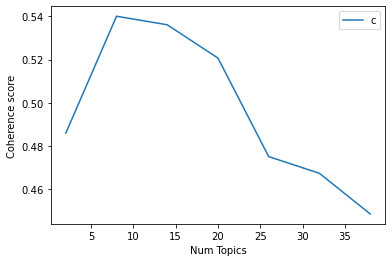

In [72]:
# draw a plot of coherence score vs. num_topics
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [73]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.4859
Num Topics = 8  has Coherence Value of 0.5401
Num Topics = 14  has Coherence Value of 0.5361
Num Topics = 20  has Coherence Value of 0.5207
Num Topics = 26  has Coherence Value of 0.4751
Num Topics = 32  has Coherence Value of 0.4673
Num Topics = 38  has Coherence Value of 0.4485


In [75]:
# Select the model and print the topics
optimal_model = model_list[1]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.024*"sale" + 0.018*"price" + 0.013*"sell" + 0.011*"lebanese" + '
  '0.010*"family" + 0.009*"period" + 0.008*"upgrade" + 0.008*"cooler" + '
  '0.007*"trust" + 0.007*"bomb"'),
 (1,
  '0.018*"people" + 0.016*"gun" + 0.014*"kill" + 0.011*"death" + 0.009*"state" '
  '+ 0.009*"child" + 0.009*"government" + 0.008*"attack" + 0.008*"say" + '
  '0.008*"law"'),
 (2,
  '0.026*"evidence" + 0.018*"faith" + 0.016*"believe" + 0.015*"sense" + '
  '0.014*"christian" + 0.013*"exist" + 0.013*"religion" + 0.012*"reason" + '
  '0.011*"belief" + 0.011*"physical"'),
 (3,
  '0.008*"car" + 0.008*"year" + 0.007*"power" + 0.006*"space" + 0.006*"new" + '
  '0.005*"state" + 0.005*"high" + 0.005*"money" + 0.005*"government" + '
  '0.004*"pay"'),
 (4,
  '0.020*"team" + 0.019*"game" + 0.017*"year" + 0.013*"play" + 0.011*"line" + '
  '0.011*"win" + 0.010*"player" + 0.008*"run" + 0.008*"get" + 0.007*"bike"'),
 (5,
  '0.616*"ax" + 0.012*"_" + 0.007*"rlk" + 0.005*"lk" + 0.004*"tm" + 0.004*"cx" '
  '+ 0.004*"ei" 

### Find the dominant topic for each document

In [98]:
### Find the dominant topic in each sentence
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
#         row = sorted(row, key=lambda x: (x[1]), reverse=True)
        row = sorted(row[0], key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

/var/folders/cq/fh2lg0p11nv1_7x21vz35f500000gq/T/ipykernel_3896/3427743477.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
/var/folders/cq/fh2lg0p11nv1_7x21vz35f500000gq/T/ipykernel_3896/3427743477.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,7,0.3864,"write, line, article, know, say, think, make, ...",From: (wheres my thing) Subject: WHAT car is t...
1,1,6,0.3177,"line, use, system, drive, host, organization, ...",From: (Guy Kuo) Subject: SI Clock Poll - Final...
2,2,7,0.5372,"write, line, article, know, say, think, make, ...",From: (Thomas E Willis) Subject: PB questions....
3,3,7,0.4576,"write, line, article, know, say, think, make, ...",From: (Joe Green) Subject: Re: Weitek P9000 ? ...
4,4,7,0.6415,"write, line, article, know, say, think, make, ...",From: (Jonathan McDowell) Subject: Re: Shuttle...
5,5,7,0.5924,"write, line, article, know, say, think, make, ...",From: (Foxvog Douglas) Subject: Re: Rewording ...
6,6,6,0.4745,"line, use, system, drive, host, organization, ...",From: (brian manning delaney) Subject: Brain T...
7,7,6,0.5812,"line, use, system, drive, host, organization, ...",From: (GRUBB) Subject: Re: IDE vs SCSI Organiz...
8,8,6,0.6656,"line, use, system, drive, host, organization, ...",From: Subject: WIn 3.0 ICON HELP PLEASE! Organ...
9,9,6,0.5399,"line, use, system, drive, host, organization, ...",From: (Stan Kerr) Subject: Re: Sigma Designs D...


### Find the most representative document for each topic

In [109]:
# Select the top 5 documents under each topic
sent_topics_sorteddf = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf = pd.concat([sent_topics_sorteddf,
                                     grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)],
                                     axis=0)

# reset index
sent_topics_sorteddf.reset_index(drop=True, inplace=True)

# reset column names
sent_topics_sorteddf.columns = ['Topic_Num', 'Topic_Perc_Contrib', 'Keywords', 'Text']

sent_topics_sorteddf.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0,0.5005,"sale, price, sell, lebanese, family, period, u...",From: (michael mchugh) Subject: Rolling Stones...
1,1,0.8071,"people, gun, kill, death, state, child, govern...",From: (Serdar Argic) Subject: As today marks t...
2,2,0.4700,"evidence, faith, believe, sense, christian, ex...",From: (Mark Baker) Subject: Re: The arrogance ...
3,3,0.7548,"car, year, power, space, new, state, high, mon...",From: (Dean Adams) Subject: Ariane v.56 Missio...
4,4,0.9140,"team, game, year, play, line, win, player, run...",From: (Rocket) Subject: NHL Final point standi...
5,5,0.9993,"ax, _, rlk, lk, tm, cx, ei, yx, dy, r",Subject: roman.bmp 12/14 From: (Cliff) Reply-T...
6,6,0.8560,"line, use, system, drive, host, organization, ...",From: (Tow Wang Hui) Subject: NEEDED: ProDesig...
7,7,0.8845,"write, line, article, know, say, think, make, ...",From: (Gordon Banks) Subject: Re: Blindsight R...


In [111]:
sent_topics_sorteddf

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0,0.5005,"sale, price, sell, lebanese, family, period, u...",From: (michael mchugh) Subject: Rolling Stones...
1,1,0.8071,"people, gun, kill, death, state, child, govern...",From: (Serdar Argic) Subject: As today marks t...
2,2,0.4700,"evidence, faith, believe, sense, christian, ex...",From: (Mark Baker) Subject: Re: The arrogance ...
3,3,0.7548,"car, year, power, space, new, state, high, mon...",From: (Dean Adams) Subject: Ariane v.56 Missio...
4,4,0.9140,"team, game, year, play, line, win, player, run...",From: (Rocket) Subject: NHL Final point standi...
5,5,0.9993,"ax, _, rlk, lk, tm, cx, ei, yx, dy, r",Subject: roman.bmp 12/14 From: (Cliff) Reply-T...
6,6,0.8560,"line, use, system, drive, host, organization, ...",From: (Tow Wang Hui) Subject: NEEDED: ProDesig...
7,7,0.8845,"write, line, article, know, say, think, make, ...",From: (Gordon Banks) Subject: Re: Blindsight R...
